In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics as tm
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

In [123]:
with open('datasets/activity_labels.txt') as f:
	defined_labels = [line.strip().split(" ")[1] for line in f]

In [124]:
lookup = pd.read_csv('datasets/RawData/labels.txt', sep = ' ', header = None)
lookup.columns = ["ExpId", "UserId", "ActId", "Start", "End"]
lookup.head()

,ExpId,UserId,ActId,Start,End
0,1,1,5,250,1232
1,1,1,7,1233,1392
2,1,1,4,1393,2194
3,1,1,8,2195,2359
4,1,1,5,2360,3374


In [125]:
lookup["Duration"] = lookup["End"]-lookup["Start"]
lookup[["ActId","Duration"]].groupby(['ActId']).min()

,Duration
ActId,
1,140
2,221
3,215
4,622
5,759
6,777
7,89
8,73
9,135


In [126]:
lookup["AdjStart"] = round(lookup["Start"] + lookup["Duration"] * 0.05)
lookup["AdjEnd"] = round(lookup["End"]- lookup["Duration"] * 0.05)

In [127]:
lookup["AdjDuration"] = lookup["AdjEnd"]-lookup["AdjStart"]
lookup[["ActId","AdjDuration"]].groupby(['ActId']).min()

,AdjDuration
ActId,
1,126.0
2,199.0
3,193.0
4,560.0
5,683.0
6,699.0
7,81.0
8,65.0
9,121.0


In [128]:
expid = 0
userid = 0
val = [7, 24, 9, 19]
test = [28, 8, 21, 3]
x_train = []
x_val = []
x_test = []
y_train = []
y_val = []
y_test = []
for _,row in lookup.iterrows():
	if expid != row["ExpId"] or userid != row["UserId"]:
		expid = int(row["ExpId"])
		userid = int(row["UserId"])
		acc_file = f'datasets/RawData/acc_exp{"{:02d}".format(expid)}_user{"{:02d}".format(userid)}.txt'
		gyro_file = f'datasets/RawData/gyro_exp{"{:02d}".format(expid)}_user{"{:02d}".format(userid)}.txt'
		acc = pd.read_csv(acc_file, sep = ' ', header = None)
		acc.columns = ["ax", "ay", "az"]
		gyro = pd.read_csv(gyro_file, sep = ' ', header = None)
		gyro.columns = ["gx", "gy", "gz"]
		data = pd.concat([acc, gyro], axis=1)
	for i in range(int(row["AdjStart"]), int(row["AdjEnd"]), 64):
		if userid in val:
			x_val.append(torch.tensor(data[i:i+64].values.astype(np.float32)))
			y_val.append(row["ActId"]-1)
		elif userid in test:
			x_test.append(torch.tensor(data[i:i+64].values.astype(np.float32)))
			y_test.append(row["ActId"]-1)
		else:
			x_train.append(torch.tensor(data[i:i+64].values.astype(np.float32)))
			y_train.append(row["ActId"]-1)

In [129]:
class TimeSeriesDataset(Dataset):
	def __init__(self, ts, labels):
		self.ts = ts
		self.labels = labels

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, idx):
		timeperiod = self.ts[idx]
		label = self.labels[idx]
		return timeperiod, label

In [130]:
train_data = TimeSeriesDataset(x_train, y_train)
val_data = TimeSeriesDataset(x_val, y_val)
test_data = TimeSeriesDataset(x_test, y_test)

In [131]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [132]:
class ClassificationMetrics(nn.Module):
    def __init__(self, num_classes: int, mode: str):
        super().__init__()
        self.num_classes = num_classes
        self.mode = mode

        self.categ_pc = tm.Precision(num_classes=self.num_classes, average="none")
        self.macro_pc = tm.Precision(num_classes=self.num_classes, average="macro")
        self.micro_pc = tm.Precision(num_classes=self.num_classes, average="micro")
        self.weigh_pc = tm.Precision(num_classes=self.num_classes, average="weighted")

        self.categ_rc = tm.Recall(num_classes=self.num_classes, average="none")
        self.macro_rc = tm.Recall(num_classes=self.num_classes, average="macro")
        self.micro_rc = tm.Recall(num_classes=self.num_classes, average="micro")
        self.weigh_rc = tm.Recall(num_classes=self.num_classes, average="weighted")

        self.categ_f1 = tm.F1(num_classes=self.num_classes, average="none")
        self.macro_f1 = tm.F1(num_classes=self.num_classes, average="macro")
        self.micro_f1 = tm.F1(num_classes=self.num_classes, average="micro")
        self.weigh_f1 = tm.F1(num_classes=self.num_classes, average="weighted")

        self.cnfs_mat = tm.ConfusionMatrix(num_classes=self.num_classes, normalize="true")

        self.mcc = tm.MatthewsCorrcoef(num_classes=self.num_classes)

    def to(self, device: torch.device):
        self.categ_pc.to(device)
        self.macro_pc.to(device)
        self.micro_pc.to(device)
        self.weigh_pc.to(device)

        self.categ_rc.to(device)
        self.macro_rc.to(device)
        self.micro_rc.to(device)
        self.weigh_rc.to(device)

        self.categ_f1.to(device)
        self.macro_f1.to(device)
        self.micro_f1.to(device)
        self.weigh_f1.to(device)

        self.cnfs_mat.to(device)

        self.mcc.to(device)

    def forward(self, x, y):
        self.categ_pc(x, y)
        self.macro_pc(x, y)
        self.micro_pc(x, y)
        self.weigh_pc(x, y)

        self.categ_rc(x, y)
        self.macro_rc(x, y)
        self.micro_rc(x, y)
        self.weigh_rc(x, y)

        self.categ_f1(x, y)
        self.macro_f1(x, y)
        self.micro_f1(x, y)
        self.weigh_f1(x, y)

        self.cnfs_mat(x, y)
        self.mcc(x, y)

In [133]:
class NeuralNetModel(LightningModule):
	def __init__(self, input_dim, hidden_size, num_classes, labels):
		super().__init__()
		self.input_dim = input_dim
		self.hidden_size = hidden_size
		self.num_classes = num_classes
		self.rnn = nn.GRU(self.input_dim, self.hidden_size, batch_first=True)
		self.dense = nn.Linear(self.hidden_size, self.hidden_size)
		self.activation = nn.Tanh()
		self.linear = nn.Linear(self.hidden_size, self.num_classes)
		self.classification = nn.Sequential(self.dense, self.activation, self.linear)
		self.loss = nn.CrossEntropyLoss()
		self.labels = labels if labels is not None else list(range(self.num_classes))

	def setup(self, stage=None) -> None:
		if stage == 'fit':
			self.val_metrics = ClassificationMetrics(self.num_classes, "val")
		if stage == 'test':
			self.test_metrics = ClassificationMetrics(self.num_classes, "test")

	def forward(self, x):
		output, h_n = self.rnn(x)
		encoding = h_n[0, :, :]
		result = self.classification(encoding)
		return result

	def configure_optimizers(self):
		return torch.optim.AdamW(self.parameters(), lr=1e-3)

	def training_step(self, batch, batch_idx):
		x, y = batch
		pred = self(x)
		y = y.type_as(pred).long()
		loss = self.loss(pred, y)
		self.log("train_loss", loss)
		return loss

	def validation_step(self, batch, batch_idx):
		x, y = batch
		pred = self(x)
		y = y.type_as(pred).long()
		loss = self.loss(pred, y)
		self.val_metrics(pred, y)
		self.log("val_loss", loss)
		self.log_scalars(self.val_metrics)

	def validation_epoch_end(self, outputs):
		self.log_nonscalars(self.val_metrics)

	def test_step(self, batch, batch_idx):
		x, y = batch
		pred = self(x)
		y = y.type_as(pred).long()
		loss = self.loss(pred, y)
		self.test_metrics(pred, y)
		self.log("test_loss", loss)
		self.log_scalars(self.test_metrics)

	def test_epoch_end(self, outputs):
		self.log_nonscalars(self.test_metrics)

	def log_scalars(self, metric: ClassificationMetrics):
		self.log(f"{metric.mode}_precision_macro", metric.macro_pc)
		self.log(f"{metric.mode}_precision_micro", metric.micro_pc)
		self.log(f"{metric.mode}_precision_weighted", metric.weigh_pc)

		self.log(f"{metric.mode}_recall_macro", metric.macro_rc)
		self.log(f"{metric.mode}_recall_micro", metric.micro_rc)
		self.log(f"{metric.mode}_recall_weighted", metric.weigh_rc)

		self.log(f"{metric.mode}_f1_macro", metric.macro_f1)
		self.log(f"{metric.mode}_f1_micro", metric.micro_f1)
		self.log(f"{metric.mode}_f1_weighted", metric.weigh_f1)

		self.log(f"{metric.mode}_mcc", metric.mcc)

	def log_nonscalars(self, metric: ClassificationMetrics):
		fig = plt.figure(figsize=(24, 24))
		cf_matrix = metric.cnfs_mat.compute().cpu().numpy()
		sb.heatmap(cf_matrix, annot=True, xticklabels=self.labels, yticklabels=self.labels, fmt='.1%')
		self.logger.experiment.add_figure(f"{metric.mode}_cnfs_mat", fig, global_step=self.current_epoch)

		categ_pc = metric.categ_pc.compute().cpu().tolist()
		pc_map = dict(zip(self.labels, categ_pc))
		self.logger.experiment.add_scalars(f"{metric.mode}_precision_categ", pc_map, global_step=self.current_epoch)

		categ_rc = metric.categ_pc.compute().cpu().tolist()
		rc_map = dict(zip(self.labels, categ_rc))
		self.logger.experiment.add_scalars(f"{metric.mode}_recall_categ", rc_map, global_step=self.current_epoch)

		categ_f1 = metric.categ_pc.compute().cpu().tolist()
		f1_map = dict(zip(self.labels, categ_f1))
		self.logger.experiment.add_scalars(f"{metric.mode}_f1_categ", f1_map, global_step=self.current_epoch)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name        | Type                  | Params
------------------------------------------------------
0 | rnn         | GRU                   | 32.4 K
1 | linear      | Linear                | 1.2 K 
2 | loss        | CrossEntropyLoss      | 0     
3 | val_metrics | ClassificationMetrics | 0     
------------------------------------------------------
33.6 K    Trainable params
0         Non-trainable params
33.6 K    Total params
0.134     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 60 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 72 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 24 nan values found in confusion matrix have been 

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 84 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 48 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 108 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/Users/georgehuang/GitRepo/olsen/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_f1_macro': 0.6948717832565308,
 'test_f1_micro': 0.889162540435791,
 'test_f1_weighted': 0.884523332118988,
 'test_loss': 0.39446792006492615,
 'test_mcc': 0.8706417679786682,
 'test_precision_macro': 0.7518275380134583,
 'test_precision_micro': 0.889162540435791,
 'test_precision_weighted': 0.8897879719734192,
 'test_recall_macro': 0.6868268251419067,
 'test_recall_micro': 0.889162540435791,
 'test_recall_weighted': 0.8891624808311462}
--------------------------------------------------------------------------------


[{'test_loss': 0.39446792006492615,
  'test_precision_macro': 0.7518275380134583,
  'test_precision_micro': 0.889162540435791,
  'test_precision_weighted': 0.8897879719734192,
  'test_recall_macro': 0.6868268251419067,
  'test_recall_micro': 0.889162540435791,
  'test_recall_weighted': 0.8891624808311462,
  'test_f1_macro': 0.6948717832565308,
  'test_f1_micro': 0.889162540435791,
  'test_f1_weighted': 0.884523332118988,
  'test_mcc': 0.8706417679786682}]

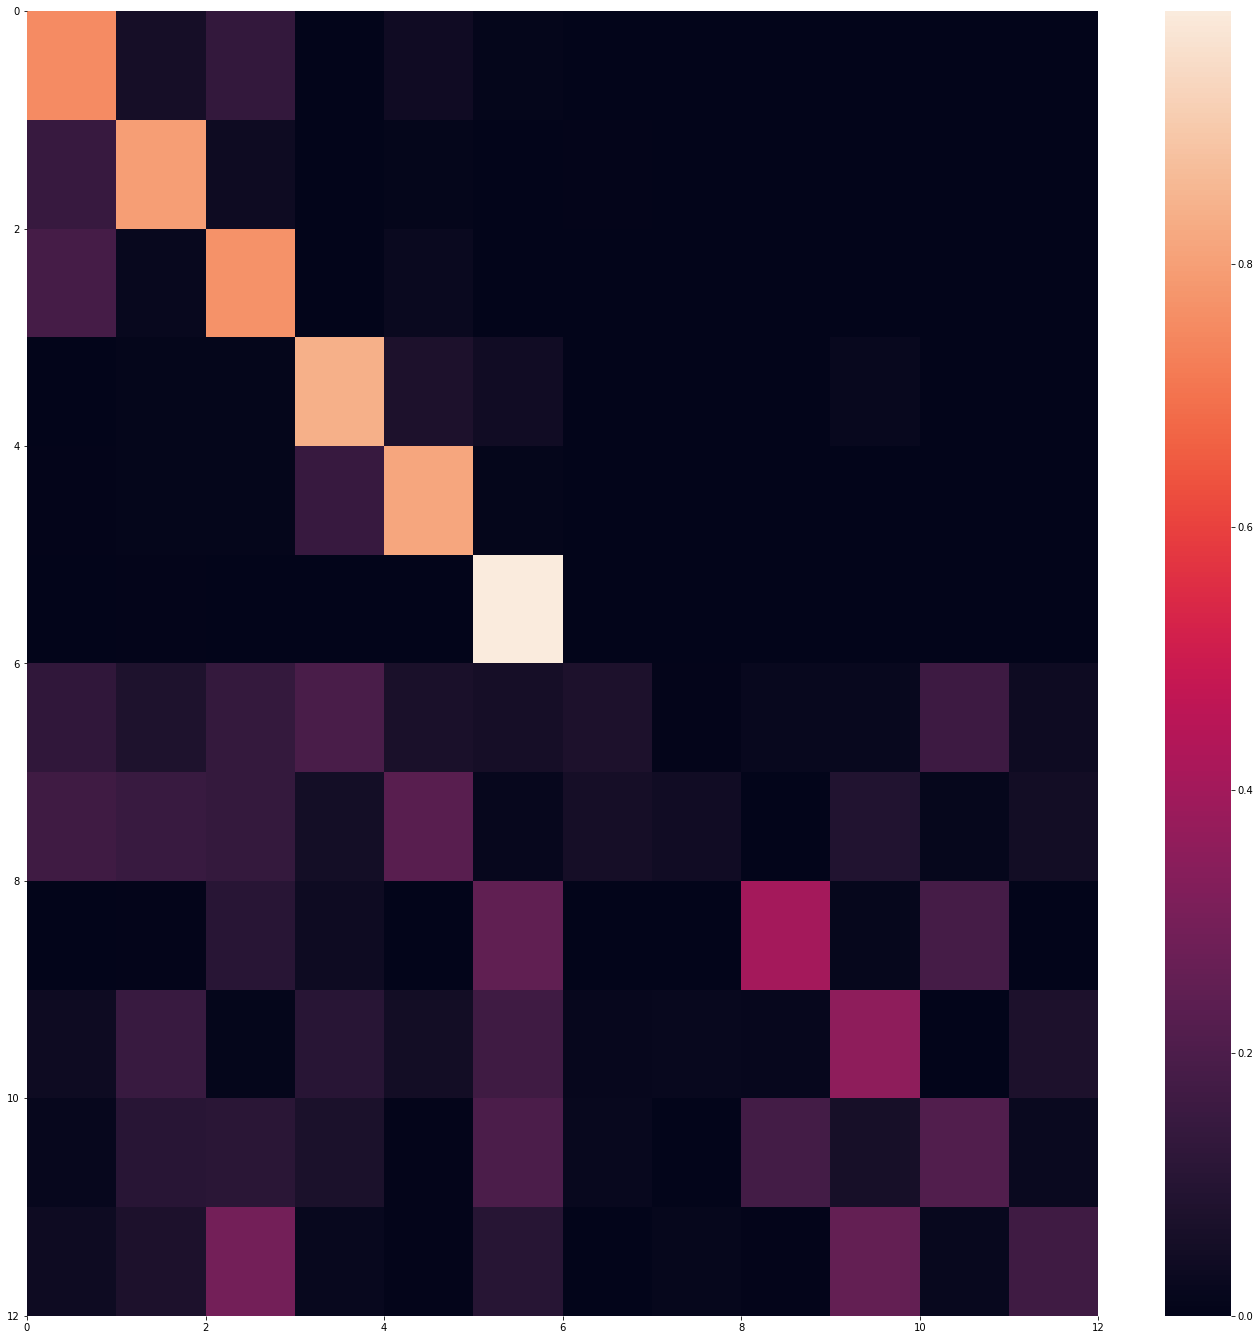

In [134]:
model = NeuralNetModel(6, 100, 12, defined_labels)
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
trainer = Trainer(gpus=0, max_epochs=50, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
trainer.test(model, test_dataloaders=test_dataloader)